In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
%cd '/content/gdrive/MyDrive/RNN'
! ls

/content/gdrive/MyDrive/RNN
IBM_2006-01-01_to_2018-01-01.csv  recurrent-neural-networks-lstm-gru.ipynb


In [4]:
# Importing the libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN, GRU, LSTM
from tensorflow.keras.optimizers import SGD, Adam
import math
from sklearn.metrics import mean_squared_error

In [5]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

**Prepare data**

In [6]:
# First, we get the data
dataset = pd.read_csv('../RNN/IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [7]:
# Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

print('training_set.shape = ', training_set.shape)
print('test_set.shape = ', test_set.shape)

training_set.shape =  (2769, 1)
test_set.shape =  (251, 1)


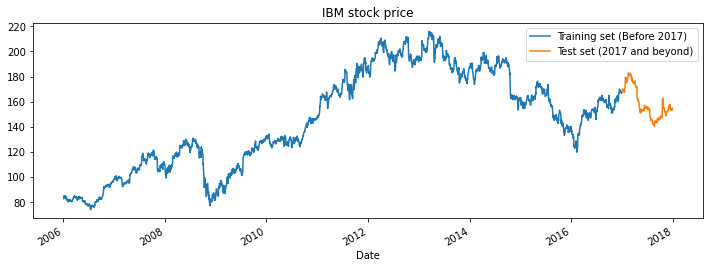

In [8]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2016'].plot(figsize=(12,4),legend=True)
dataset["High"]['2017':].plot(figsize=(12,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [9]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

print('training_set_scaled.shape = ', training_set_scaled.shape)

training_set_scaled.shape =  (2769, 1)


In [10]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60, 2769):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train.shape = ', X_train.shape)
print('y_train.shape = ', y_train.shape)

X_train.shape =  (2709, 60)
y_train.shape =  (2709,)


In [11]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print('X_train.shape = ', X_train.shape)

X_train.shape =  (2709, 60, 1)


**1. LSTM model**

In [12]:
# The LSTM architecture
regressorLSTM = Sequential()
# First LSTM layer with Dropout regularisation
regressorLSTM.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressorLSTM.add(Dropout(0.2))
# Second LSTM layer
regressorLSTM.add(LSTM(50, return_sequences=True))
regressorLSTM.add(Dropout(0.2))
# Third LSTM layer
regressorLSTM.add(LSTM(50, return_sequences=True))
regressorLSTM.add(Dropout(0.2))
# Fourth LSTM layer
regressorLSTM.add(LSTM(50))
regressorLSTM.add(Dropout(0.2))
# The output layer
regressorLSTM.add(Dense(1))

regressorLSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [13]:
# Compiling the LSTM
regressorLSTM.compile(optimizer='adam', loss='mse')
# Fitting to the training set
lstm = regressorLSTM.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
85/85 [==============================] - 15s 62ms/step - loss: 0.0237
Epoch 2/50
85/85 [==============================] - 5s 62ms/step - loss: 0.0054
Epoch 3/50
85/85 [==============================] - 5s 62ms/step - loss: 0.0046
Epoch 4/50
85/85 [==============================] - 5s 62ms/step - loss: 0.0047
Epoch 5/50
85/85 [==============================] - 5s 62ms/step - loss: 0.0043
Epoch 6/50
85/85 [==============================] - 5s 62ms/step - loss: 0.0038
Epoch 7/50
85/85 [==============================] - 5s 62ms/step - loss: 0.0041
Epoch 8/50
85/85 [==============================] - 5s 62ms/step - loss: 0.0040
Epoch 9/50
85/85 [==============================] - 6s 65ms/step - loss: 0.0033
Epoch 10/50
85/85 [==============================] - 6s 65ms/step - loss: 0.0032
Epoch 11/50
85/85 [==============================] - 5s 62ms/step - loss: 0.0033
Epoch 12/50
85/85 [==============================] - 5s 61ms/step - loss: 0.0032
Epoch 13/50
85/85 [=================

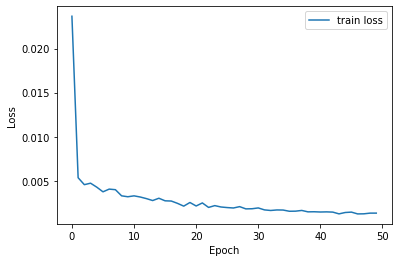

In [14]:
# loss
plt.plot(lstm.history['loss'], label='train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'], dataset["High"]['2017':]), axis=0)
inputs = dataset_total[len(dataset_total) - len(test_set) - 60:].values
print('dataset_total.shape = ', dataset_total.shape)
print('inputs.shape = ', inputs.shape)

inputs = inputs.reshape(-1,1)
print('inputs.shape = ', inputs.shape)

inputs  = sc.transform(inputs)
print('inputs.shape = ', inputs.shape)

dataset_total.shape =  (3020,)
inputs.shape =  (311,)
inputs.shape =  (311, 1)
inputs.shape =  (311, 1)


In [16]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60, 311):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
print('X_test.shape = ', X_test.shape)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print('X_test.shape = ', X_test.shape)

LSTM_predicted_stock_price = regressorLSTM.predict(X_test)
LSTM_predicted_stock_price = sc.inverse_transform(LSTM_predicted_stock_price)
print('LSTM_predicted_stock_price.shape = ', LSTM_predicted_stock_price.shape)

X_test.shape =  (251, 60)
X_test.shape =  (251, 60, 1)
LSTM_predicted_stock_price.shape =  (251, 1)


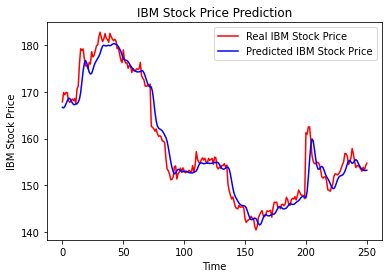

In [17]:
# Visualizing the results for LSTM
plot_predictions(test_set, LSTM_predicted_stock_price)

In [18]:
# Evaluating our model
return_rmse(test_set, LSTM_predicted_stock_price)

The root mean squared error is 2.584891105097683.


**2. GRU model**

In [19]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(1))

regressorGRU.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 60, 50)            7950      
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 gru_1 (GRU)                 (None, 60, 50)            15300     
                                                                 
 dropout_5 (Dropout)         (None, 60, 50)            0         
                                                                 
 gru_2 (GRU)                 (None, 60, 50)            15300     
                                                                 
 dropout_6 (Dropout)         (None, 60, 50)            0         
                                                                 
 gru_3 (GRU)                 (None, 50)               

In [20]:
# Compiling the RNN
#regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
regressorGRU.compile(optimizer='adam', loss='mse')
# Fitting to the training set
gru = regressorGRU.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
85/85 [==============================] - 12s 60ms/step - loss: 0.0248
Epoch 2/50
85/85 [==============================] - 5s 60ms/step - loss: 0.0045
Epoch 3/50
85/85 [==============================] - 5s 60ms/step - loss: 0.0038
Epoch 4/50
85/85 [==============================] - 5s 60ms/step - loss: 0.0037
Epoch 5/50
85/85 [==============================] - 5s 59ms/step - loss: 0.0032
Epoch 6/50
85/85 [==============================] - 5s 59ms/step - loss: 0.0031
Epoch 7/50
85/85 [==============================] - 5s 59ms/step - loss: 0.0028
Epoch 8/50
85/85 [==============================] - 5s 59ms/step - loss: 0.0033
Epoch 9/50
85/85 [==============================] - 5s 59ms/step - loss: 0.0026
Epoch 10/50
85/85 [==============================] - 5s 59ms/step - loss: 0.0025
Epoch 11/50
85/85 [==============================] - 5s 59ms/step - loss: 0.0025
Epoch 12/50
85/85 [==============================] - 5s 59ms/step - loss: 0.0026
Epoch 13/50
85/85 [=================

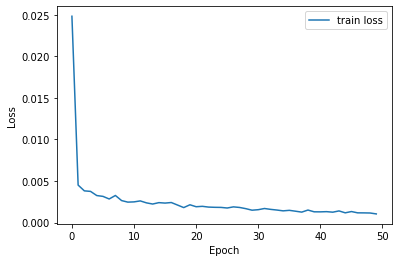

In [21]:
# loss
plt.plot(gru.history['loss'], label='train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60, 311):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

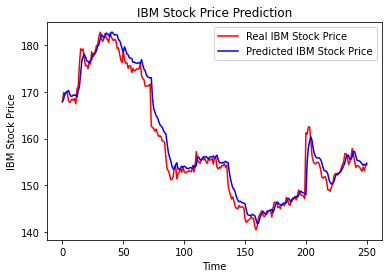

In [23]:
# Visualizing the results for GRU
plot_predictions(test_set, GRU_predicted_stock_price)

In [24]:
# Evaluating GRU
return_rmse(test_set, GRU_predicted_stock_price)

The root mean squared error is 2.168854567454493.


**3. SimpleRNN model**

In [25]:
# The RNN architecture
regressorRNN = Sequential()
# First RNN layer with Dropout regularisation
regressorRNN.add(SimpleRNN(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressorRNN.add(Dropout(0.2))
# Second RNN layer
regressorRNN.add(SimpleRNN(50, return_sequences=True))
regressorRNN.add(Dropout(0.2))
# Third RNN layer
regressorRNN.add(SimpleRNN(50, return_sequences=True))
regressorRNN.add(Dropout(0.2))
# Fourth RNN layer
regressorRNN.add(SimpleRNN(50))
regressorRNN.add(Dropout(0.2))
# The output layer
regressorRNN.add(Dense(1))

regressorRNN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 60, 50)            2600      
                                                                 
 dropout_8 (Dropout)         (None, 60, 50)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 60, 50)            5050      
                                                                 
 dropout_9 (Dropout)         (None, 60, 50)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 60, 50)            5050      
                                                                 
 dropout_10 (Dropout)        (None, 60, 50)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 50)               

In [26]:
# Compiling the RNN
regressorRNN.compile(optimizer='adam', loss='mse')
# Fitting to the training set
rnn = regressorRNN.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
85/85 [==============================] - 31s 333ms/step - loss: 0.3547
Epoch 2/50
85/85 [==============================] - 29s 337ms/step - loss: 0.1756
Epoch 3/50
85/85 [==============================] - 29s 336ms/step - loss: 0.1070
Epoch 4/50
85/85 [==============================] - 29s 339ms/step - loss: 0.0664
Epoch 5/50
85/85 [==============================] - 29s 336ms/step - loss: 0.0479
Epoch 6/50
85/85 [==============================] - 28s 324ms/step - loss: 0.0345
Epoch 7/50
85/85 [==============================] - 27s 319ms/step - loss: 0.0276
Epoch 8/50
85/85 [==============================] - 28s 330ms/step - loss: 0.0226
Epoch 9/50
85/85 [==============================] - 28s 326ms/step - loss: 0.0184
Epoch 10/50
85/85 [==============================] - 28s 328ms/step - loss: 0.0146
Epoch 11/50
85/85 [==============================] - 28s 327ms/step - loss: 0.0121
Epoch 12/50
85/85 [==============================] - 27s 319ms/step - loss: 0.0111
Epoch 13/50
8

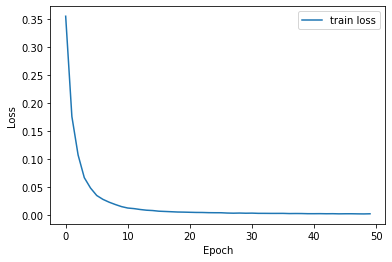

In [27]:
# loss
plt.plot(rnn.history['loss'], label='train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60, 311):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
RNN_predicted_stock_price = regressorRNN.predict(X_test)
RNN_predicted_stock_price = sc.inverse_transform(RNN_predicted_stock_price)

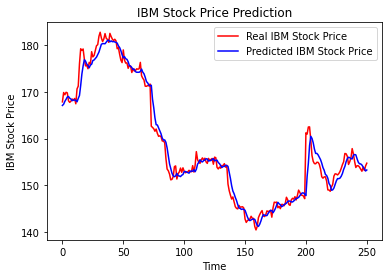

In [29]:
# Visualizing the results for RNN
plot_predictions(test_set, RNN_predicted_stock_price)

In [30]:
# Evaluating RNN
return_rmse(test_set, RNN_predicted_stock_price)

The root mean squared error is 2.124389644171504.


**Compare predictions made by RNN, GRU, LSTM models by plotting data in a single graph**

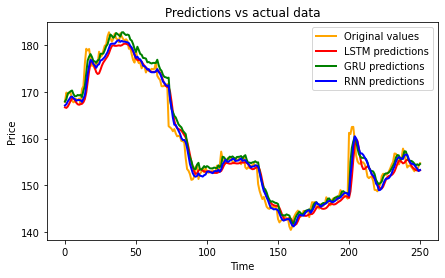

In [31]:
plt.figure(figsize=(7,4))

plt.plot(test_set, c="orange", linewidth=2, label="Original values")
plt.plot(LSTM_predicted_stock_price, c="red", linewidth=2, label="LSTM predictions")
plt.plot(GRU_predicted_stock_price, c="green", linewidth=2, label="GRU predictions")
plt.plot(RNN_predicted_stock_price, c="blue", linewidth=2, label="RNN predictions")
plt.legend()
plt.title("Predictions vs actual data", fontsize=12)
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

The end